# Project 2: Spam/Ham Classification

This is my solution for UCB [Data100](https://ds100.org) Project2 Spam/Ham Classification. The notebook is original from [Spring 2022](https://github.com/DS-100/sp22). 

In this project, participants were asked to create their own classifier to distinguish spam emails from ham (non-spam) emails. They were only allowed to train logistic regression models. No decision trees, random forests, k-nearest-neighbors, neural nets, etc.

Since only logistic regression models were allowed, I focused on feature selection and **proposed a feature selection method using conditional probability**.

### Part 0: Setup

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

np.random.seed(42)

In [2]:
# training_data_filename = './train.csv'
# test_data_filename = './test.csv'

original_training_data = pd.read_csv(training_data_filename)
original_test_data = pd.read_csv(test_data_filename)

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,URL: http://boingboing.net/#85534171\n Date: N...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",URL: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<HTML>\n <HEAD>\n </HEAD>\n <BODY>\n <FONT SIZ...,1
3,3,Subject: liberal defnitions\n,Depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


In [3]:
# Fill any missing or NAN values
original_training_data = original_training_data.fillna('')

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

def words_in_texts(words, texts):
    '''
    Args:
        words (list): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    vectorizer = CountVectorizer(binary=True, vocabulary=words)
    return vectorizer.transform(texts).toarray()

### Part 1: Feature Selection

I focus only on finding words with ability to distinguish emails. Roughly speaking, we need to find words with high frequency of occurrence in spam emails. But a word with a high frequency of occurrence in spam emails may also have a high frequency of occurrence in ham emails, such as a stop word ("the", "a", "and", "in"). So frequency of occurrence is not an appropriate metric for our goal.

Note that our goal is to find "spam words" such that,  

&nbsp;&nbsp;&nbsp;&nbsp; If the word appears in an email, that email is likely to be spam, **while it is not likely to be ham**.

Using conditional probability, this means 

$$
P(spam \mid word) \rightarrow 1
$$

Since

$$
P(ham \mid word) = 1 - P(spam \mid word)
$$

Then
$$
P(ham \mid word) \rightarrow 0
$$

We can see that conditional probability is an appropriate metric of our goal.

Meanwhile, finding "ham words" will also be helpful. Therefore, we need to find words such that

$$
P(spam \mid word) \rightarrow 1
$$

or 

$$
P(ham \mid word) \rightarrow 1
$$

Let's define a word's "ability to distinguish emails" as 

$$
d = \max(P(spam \mid word), P(ham \mid word))
$$

To calculate the conditional probability, we use the formula

$$
P(A \mid B) = \frac{P(AB)}{P(B)}
$$

and estimate the probability with the frequency.

In [5]:
# Emails processing functions

import re
from bs4 import BeautifulSoup

def remove_html(s):
    soup = BeautifulSoup(s, 'lxml')
    for sp in soup(['script', 'style', 'head', 'meta', 'noscript']):
        sp.decompose()
    s = ' '.join(soup.stripped_strings)
    return s

def clean_email(str_email):
    body = remove_html(str_email)
    punctuation = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~'
    body = re.sub('[{}]'.format(punctuation), ' ', body)
    body = re.sub('\n+', ' ', body)
    body = re.sub('\\s+', ' ', body)
    body = re.sub(r'[0-9]+', '(escapenumber)', body)
    body = body.lower()
    body = re.sub(r'[a-z0-9]{20,}', '(escapelong)', body)
    return body

def preprocess_df_email(df_email):
    df_email = df_email.copy()
    df_email['email'] = df_email['email'].map(clean_email)
    return df_email

def clean_df_email(df_email):
    df_email = df_email.copy()
    df_email['email'] = df_email['email'].map(clean_email)
    df_email.drop_duplicates(subset='email', inplace=True)
    # Drop processed emails without words
    df_email = df_email[df_email['email'].str.contains(r"\b\w+\b")]
    return df_email

In [6]:
from collections import Counter
from sklearn.feature_selection import f_classif

def cal_df_ability_distinguish(df_email, metric='conditional_probability'):

    df_email_spam = df_email[df_email['spam'] == 1]
    df_email_ham = df_email[df_email['spam'] == 0]

    dict_count_spam_word = Counter(word for email in df_email_spam['email'] for word in set(email.split()))
    dict_count_ham_word = Counter(word for email in df_email_ham['email'] for word in set(email.split()))

    df_spam_word = pd.DataFrame.from_dict(dict_count_spam_word, orient='index').reset_index()
    df_ham_word = pd.DataFrame.from_dict(dict_count_ham_word, orient='index').reset_index()

    df_ability = pd.merge(left=df_spam_word, right=df_ham_word, on='index').fillna(0)
    df_ability.columns = ['word', 'count_spam', 'count_ham']

    count_emails = len(df_email)
    df_ability['frequency_spam_word'] = df_ability['count_spam'] / count_emails
    df_ability['frequency_ham_word'] = df_ability['count_ham'] / count_emails
    df_ability['frequency_word'] = df_ability['frequency_spam_word'] + df_ability['frequency_ham_word']

    df_ability['probability_spam_word'] = df_ability['frequency_spam_word'] / df_ability['frequency_word']
    df_ability['probability_ham_word'] = 1 - df_ability['probability_spam_word']
    df_ability['conditional_probability'] = df_ability[['probability_spam_word', 'probability_ham_word']].max(axis=1)

    X = words_in_texts(df_ability['word'], df_email['email'])
    y = df_email['spam']
    
    # I also calculate the F value, since it's a possible metric.
    f, _ = f_classif(X, y)
    df_ability['f_value'] = f
    
    return df_ability.sort_values(by=metric, ascending=False).reset_index(drop=True)

In [7]:
df_email_cleaned = clean_df_email(original_training_data)
df_ability = cal_df_ability_distinguish(df_email_cleaned)
df_ability

,word,count_spam,count_ham,frequency_spam_word,frequency_ham_word,frequency_word,probability_spam_word,probability_ham_word,conditional_probability,f_value
0,rpm,1,406,0.000179,0.072760,0.072939,0.002457,0.997543,0.997543,167.976241
1,wed,1,234,0.000179,0.041935,0.042115,0.004255,0.995745,0.995745,85.426231
2,wrote,6,1370,0.001075,0.245520,0.246595,0.004360,0.995640,0.995640,748.695965
3,tue,1,194,0.000179,0.034767,0.034946,0.005128,0.994872,0.994872,73.347533
4,cheers,1,193,0.000179,0.034588,0.034767,0.005155,0.994845,0.994845,72.938070
...,...,...,...,...,...,...,...,...,...,...
11944,mandy,1,1,0.000179,0.000179,0.000358,0.500000,0.500000,0.500000,0.529029
11945,alright,2,2,0.000358,0.000358,0.000717,0.500000,0.500000,0.500000,1.058537
11946,saddled,1,1,0.000179,0.000179,0.000358,0.500000,0.500000,0.500000,0.529029
11947,furnished,2,2,0.000358,0.000358,0.000717,0.500000,0.500000,0.500000,1.058537


We can see that words with high conditional probability may have a low frequency of occurrence in the entire dataset. Using these words as features can only distinguish particular emails. So I set a threshold for the frequency.

In [8]:
class EmailTransformer:

    def __init__(self):
        self.df_ability = pd.DataFrame()
        self.words = []
    
    def set_words(self, words):
        self.words = words

    def fit(self, 
            df_email, 
            metric='conditional_probability', 
            num_words=500, 
            selete_method='threshold_frequency', 
            **kwargs):

        self.df_ability = cal_df_ability_distinguish(df_email, metric)

        if selete_method == 'threshold_frequency':
            high_ability = self.df_ability[self.df_ability['frequency_word'] > kwargs['threshold_frequency']]
            high_ability = high_ability.nlargest(n=num_words, columns=metric)
            self.words = high_ability['word'].to_numpy()
        else:
            high_ability = self.df_ability.nlargest(n=num_words, columns=metric)
            self.words = high_ability['word'].to_numpy()

    def transform(self, df_email):
        return words_in_texts(self.words, df_email['email'])
    
    def fit_transform(self, 
                      df_email, 
                      metric='conditional_probability', 
                      num_words=100, 
                      selete_method='threshold_frequency', 
                      **kwargs):

        self.fit(df_email, metric, num_words, selete_method, **kwargs)
        return self.transform(df_email)
    
    def get_df_ability(self):
        return self.df_ability
    
    def get_words(self):
        return self.words

### Part 2: Tune Hyperparameters

There are two hyperparameters of our email transformer: number of words and threshold. I exhaustively search over a range of values to find the best one, using 4-fold cross-validation average accuracy as the metric.

100%|██████████| 200/200 [12:43<00:00,  3.82s/it]


[Text(0.5, 1.0, 'Tune Hyperparameters')]

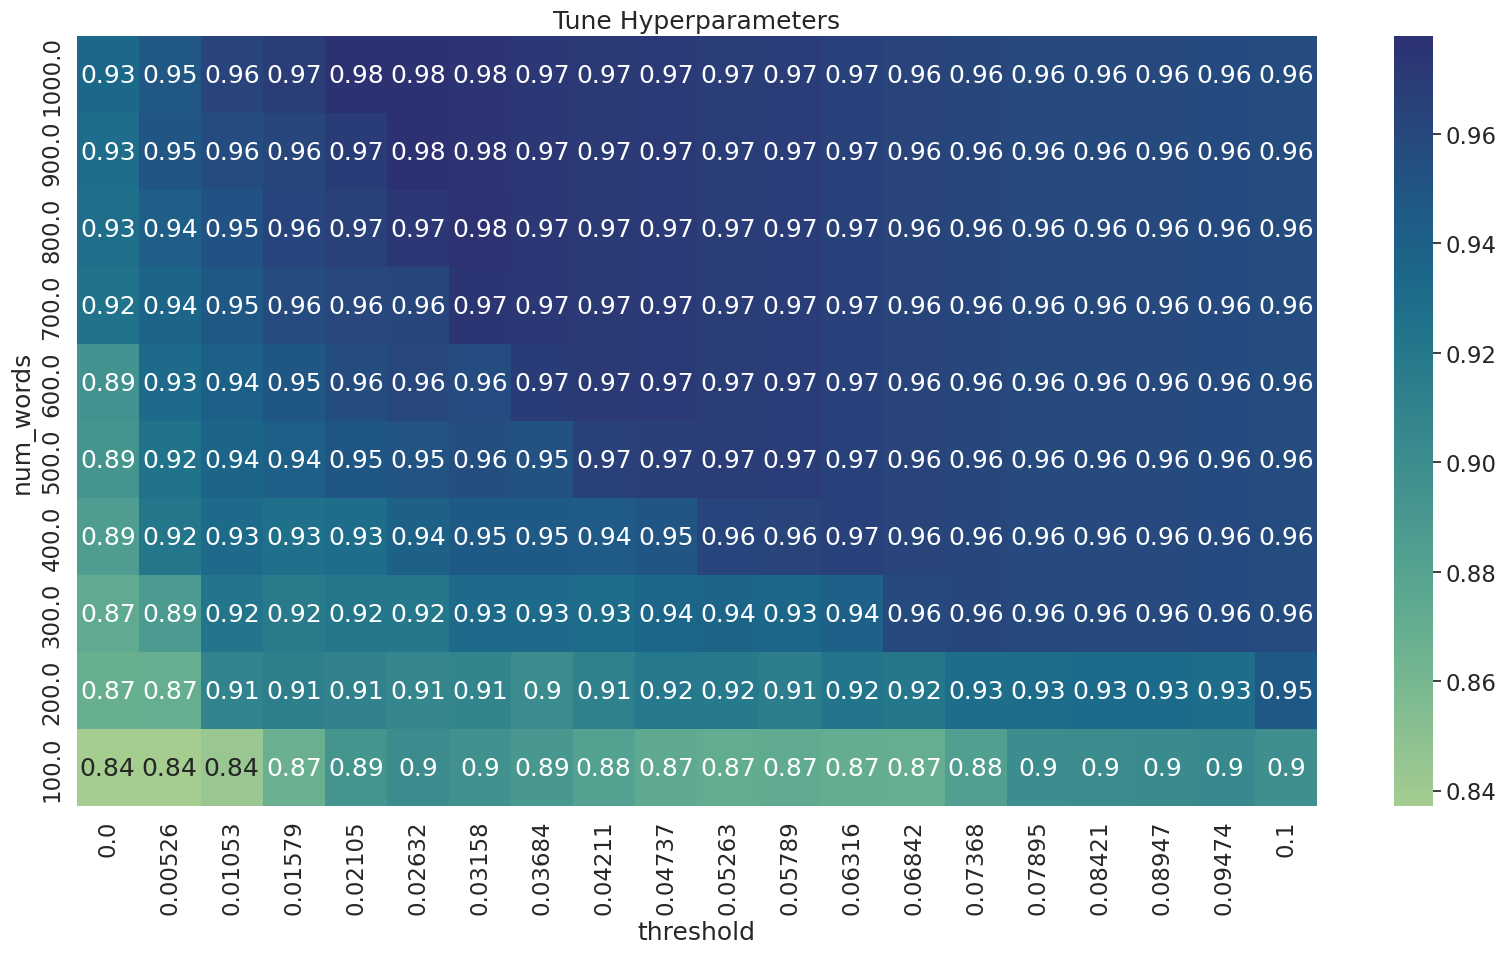

In [9]:
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

df_email = clean_df_email(original_training_data)
model = LogisticRegression()

range_parameter = {'num_words': range(100, 1001, 100), 
                   'threshold': np.round(np.linspace(0, 0.1, 20), 5)}
grid_parameter = ParameterGrid(range_parameter)

df_accuracy_parameter = pd.DataFrame(columns=['threshold', 'num_words', 'metric'])

for g in tqdm(grid_parameter):
    num = g['num_words']
    t = g['threshold']
    transform = EmailTransformer()
    X = transform.fit_transform(df_email, 
                                metric='conditional_probability', 
                                num_words=num, 
                                selete_method='threshold_frequency', 
                                threshold_frequency=t)
    y = df_email['spam']

    accuracy_mean = np.round(np.mean(cross_val_score(model, X, y, cv=4)), 5)
    df_accuracy_parameter.loc[len(df_accuracy_parameter.index)] = [t, num, accuracy_mean] 

fig, ax = plt.subplots(figsize=(20, 10))
df_pivot = df_accuracy_parameter.pivot(index='num_words', columns='threshold', values='metric').sort_values(by='num_words', ascending=False)
sns.heatmap(df_pivot, annot=True, cmap="crest").set(title='Tune Hyperparameters')

### Part 3: ROC Curve

In most cases we won't be able to get 0 false positives and 0 false negatives, so we have to compromise. For example, in the case of cancer screenings, false negatives are comparatively worse than false positives — a false negative means that a patient might not discover that they have cancer until it's too late, whereas a patient can just receive another screening for a false positive.

Recall that logistic regression calculates the probability that an example belongs to a certain class. Then, to classify an example we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. However, *we can adjust that cutoff*: we can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam, for example. This is how we can trade off false positives and false negatives.

The ROC curve shows this trade off for each possible cutoff probability. In the cell below, plot a ROC curve for the final classifier on the training data.

Accuracy of the final model on the training data: 0.99821


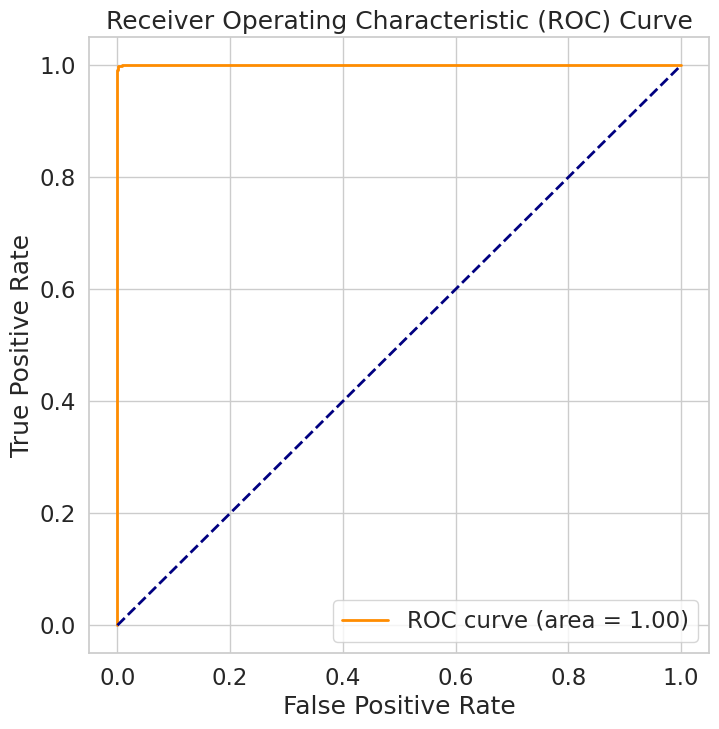

In [10]:
from sklearn.metrics import roc_curve, auc

df_email = clean_df_email(original_training_data)
transformer_final = EmailTransformer()
X = transformer_final.fit_transform(df_email, 
                                    metric='conditional_probability', 
                                    num_words=1000, 
                                    selete_method='threshold_frequency', 
                                    threshold_frequency=0.02632)
y = df_email['spam']
model_final = LogisticRegression()
model_final.fit(X, y)
y_prob = model_final.predict_proba(X)[:, 1]

fpr, tpr, thresholds = roc_curve(y, y_prob)
roc_auc = auc(fpr, tpr)
print(f'Accuracy of the final model on the training data: {np.round(model_final.score(X, y), 5)}')

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [11]:
# Show words seleted.
transformer_final.get_words()

array(['rpm', 'wed', 'wrote', 'tue', 'cheers', 'gary', 'apt', 'aug',
       '(escapenumber)t(escapenumber)', 'jul', 'thu', 'install', 'chris',
       'sep', 'fri', 'comment', 'default', 'admin', 'perl', 'anyway',
       'seems', 'writes', 'mailings', "wasn't", 'networks', 'log',
       'archives', 'workers', 'guess', 'installed', 'looks', 'microsoft',
       'article', 'upgrade', 'pm', 'sun', "i'd", "'", 'lines', 'supplied',
       'os', 'cool', 'hardware', 'david', 'posted', 'images',
       'v(escapenumber)', 'particular', 'editor', 'hat', 'perhaps',
       'written', 'issues', 'root', 'url', "i've", 'running', 'stuff',
       'linux', 'built', 'useful', 'september', "i'm", 'interesting',
       '(escapenumber)pm', 'monday', 'seem', 'tech', 'ilug', 'sort',
       'digital', 'users', 'august', 'org', 'groups', '(escapenumber)am',
       'mon', 'probably', 'date', 'mailman', 'pretty', 'version',
       'update', 'story', 'quite', "doesn't", 'fine', 'war', 'guaranteed',
       'file', '

### Part 4: Test Predictions


In [12]:
test_data = preprocess_df_email(original_test_data)
X = transformer_final.transform(test_data)
test_predictions = model_final.predict(X)